# PHYS 3009: TeV Gamma-Ray Data Analysis with GammaPy

This jupyter notebook presents a quick analysis of H.E.S.S. observations of the Crab Nebula. The data set is part of the first public test data release. You can find more information here: https://www.mpi-hd.mpg.de/hfm/HESS/pages/dl3-dr1/

The analysis is performed using gammapy, a community-developed, open-source Python package for gamma-ray astronomy (https://docs.gammapy.org/). More information on the individual data analysis steps can be found in the gammapy tutorials: https://docs.gammapy.org/1.1/tutorials/index.html

## Preparation

### Imports
Let's start with importing the modules that we used in the last notebook.

In [1]:
import matplotlib.pyplot as plt

from numpy import sqrt

import astropy.units as u

from astropy.coordinates import (
    SkyCoord, 
    Angle,
)


from gammapy.utils.check import check_tutorials_setup

from gammapy.data import (
    DataStore,
    EventList,
)

from gammapy.stats import WStatCountsStatistic

from gammapy.maps import Map

### Data download
The following lines check the setup and download the data.

In [2]:
check_tutorials_setup()

201MB [00:14, 14.1MB/s]                                                         



*** You might want to declare GAMMAPY_DATA env variable
export GAMMAPY_DATA=gammapy-data/1.1


System:

	python_executable      : /home/komin/anaconda3/envs/gammapy-1.1/bin/python 
	python_version         : 3.9.16     
	machine                : x86_64     
	system                 : Linux      


Gammapy package:

	version                : 1.1        
	path                   : /home/komin/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/gammapy 


Other packages:

	numpy                  : 1.24.3     
	scipy                  : 1.10.1     
	astropy                : 5.3        
	regions                : 0.7        
	click                  : 8.1.3      
	yaml                   : 6.0        
	IPython                : 8.7.0      
	jupyterlab             : 3.5.3      
	matplotlib             : 3.7.1      
	pandas                 : 1.5.2      
	healpy                 : 1.16.2     
	iminuit                : 2.21.3     
	sherpa                 : 4.15.1     
	naima                  : 0.10.

In [3]:
#import os
#os.environ['GAMMAPY_DATA'] = './gammapy-data'

In [4]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/1.1/hess-dl3-dr1")

In [5]:
data_store.info()

Data store:
HDU index table:
BASE_DIR: gammapy-data/1.1/hess-dl3-dr1
Rows: 630
OBS_ID: 20136 -- 47829
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_3d', 'edisp_2d', 'events', 'gti', 'psf_table']


Observation table:
Observatory name: 'N/A'
Number of observations: 105



Expected output:

```
Data store:
HDU index table:
BASE_DIR: gammapy-data/1.1/hess-dl3-dr1
Rows: 630
OBS_ID: 20136 -- 47829
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_3d', 'edisp_2d', 'events', 'gti', 'psf_table']


Observation table:
Observatory name: 'N/A'
Number of observations: 105
```

### Run Selection

We set the source position. frame='icrs' indicates that we are using coordinates in right ascension and declination.

In [6]:
source_pos = SkyCoord(83.63311446*u.deg, 22.01448714*u.deg, frame='icrs')

In [7]:
selectradius = 2.5*u.deg

In [8]:
conesearch = data_store.obs_table.select_sky_circle(source_pos, selectradius)

In [9]:
runlist = conesearch['OBS_ID'].value

In [10]:
print(runlist)

[23523 23526 23559 23592]


In [11]:
len(runlist)

4

In [12]:
observations = data_store.get_observations(runlist)

We create a dictionary where we will store final results which we produce along the way.

In [13]:
final_results = {}

Let's add some information to our results:

In [14]:
final_results['run list'] = runlist

## Sky Maps

### Geometries

In the last notebook we binned all events into a two-dimensional map with coordinates Right Ascension and Declination:

In [15]:
map_crab = Map.create(binsz=0.01*u.deg, 
                      width=(5*u.deg, 5*u.deg), 
                      skydir=source_pos, 
                      frame='icrs')

The axes of our map are stored in a geometry:

In [16]:
map_crab.geom

WcsGeom

	axes       : ['lon', 'lat']
	shape      : (500, 500)
	ndim       : 2
	frame      : icrs
	projection : CAR
	center     : 83.6 deg, 22.0 deg
	width      : 5.0 deg x 5.0 deg
	wcs ref    : 83.6 deg, 22.0 deg

We now want to bin the events into RA, Dec and energy. We will need a three-dimensional geometry.

In [17]:
# minimum and maximum energy for the analysis
Emin =0.1*u.TeV
Emax = 50*u.TeV

# number of energy bins in the map
map_nEbins = 6

# width of the map
map_width = 8*u.deg

# bin size of the map
map_binsz = 0.025*u.deg

# maximumum offset
offset_max = 2.5*u.deg

In [18]:
from gammapy.maps import MapAxis, WcsGeom

In [19]:
map_energy_axis = MapAxis.from_energy_bounds(Emin, Emax,
                                             nbin=map_nEbins, 
                                             name="energy")

map_geom = WcsGeom.create(skydir=source_pos,
                          axes=[map_energy_axis],
                          width=map_width,
                          binsz=map_binsz)

In [20]:
map_geom

WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (320, 320, 6)
	ndim       : 3
	frame      : icrs
	projection : CAR
	center     : 83.6 deg, 22.0 deg
	width      : 8.0 deg x 8.0 deg
	wcs ref    : 83.6 deg, 22.0 deg

In [21]:
#We will also need an axis for true energy:

energy_axis_true = MapAxis.from_energy_bounds(0.08*u.TeV, 80*u.TeV,
                                              nbin=8,
                                              per_decade=True,
                                              name="energy_true")

### MapDatasetMaker
We will now use gammapy code to do the binning of our event lists. Objects that manipulate data in gammapy are called Makers. We start with a DatasetMaker.

In [22]:
from gammapy.datasets import MapDataset

from gammapy.makers import MapDatasetMaker

In [23]:
map_empty = MapDataset.create(map_geom, 
                              name='empty', 
                              energy_axis_true=energy_axis_true
                             )

In [24]:
map_maker = MapDatasetMaker()

We will test everything on the first run:

In [25]:
obs = observations[0]

In [26]:
map_dataset = map_maker.run(map_empty, obs)

/home/komin/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/gammapy/utils/interpolation.py:185: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


array([[<WCSAxes: title={'center': 'Energy 100 GeV - 282 GeV'}>,
        <WCSAxes: title={'center': 'Energy 282 GeV - 794 GeV'}>,
        <WCSAxes: title={'center': 'Energy 794 GeV - 2.24 TeV'}>],
       [<WCSAxes: title={'center': 'Energy 2.24 TeV - 6.30 TeV'}>,
        <WCSAxes: title={'center': 'Energy 6.30 TeV - 17.7 TeV'}>,
        <WCSAxes: title={'center': 'Energy 17.7 TeV - 50.0 TeV'}>]],
      dtype=object)

/home/komin/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/komin/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/komin/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)


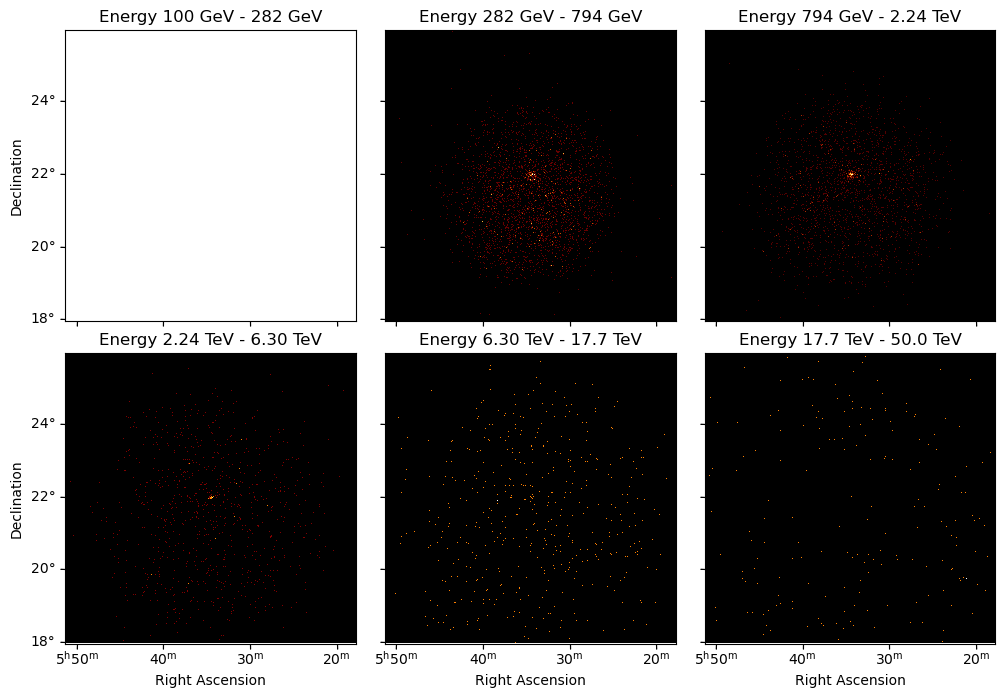

In [27]:
map_dataset.counts.plot_grid()

In [28]:
#map_dataset.counts_off

### SafeMaskMaker
We want to reject badly reconstructed events. This could be events with a very large distance from the camera centre (outside the camera) or at low energies where the sensitivity of the instruments is too low. We will reject all events outside a radius of 2.5 deg and where the sensitivity drops below 10% of the maximum value. The SafeMaskMaker will do that for us.

<WCSAxes: >

/home/komin/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/komin/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/komin/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)


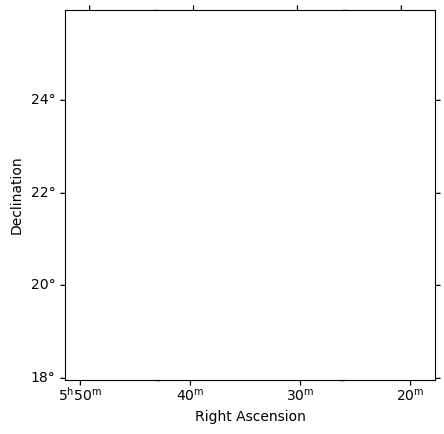

In [29]:
map_dataset.mask_image.plot()

In [30]:
from gammapy.makers import SafeMaskMaker

In [31]:
safe_mask_maker = SafeMaskMaker(methods=["offset-max", "aeff-max"], 
                                offset_max=offset_max,
                                aeff_percent=10
                               )

In [32]:
map_dataset = safe_mask_maker.run(map_dataset, obs)

array([[<WCSAxes: title={'center': 'Energy 100 GeV - 282 GeV'}>,
        <WCSAxes: title={'center': 'Energy 282 GeV - 794 GeV'}>,
        <WCSAxes: title={'center': 'Energy 794 GeV - 2.24 TeV'}>],
       [<WCSAxes: title={'center': 'Energy 2.24 TeV - 6.30 TeV'}>,
        <WCSAxes: title={'center': 'Energy 6.30 TeV - 17.7 TeV'}>,
        <WCSAxes: title={'center': 'Energy 17.7 TeV - 50.0 TeV'}>]],
      dtype=object)

/home/komin/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/komin/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/komin/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)


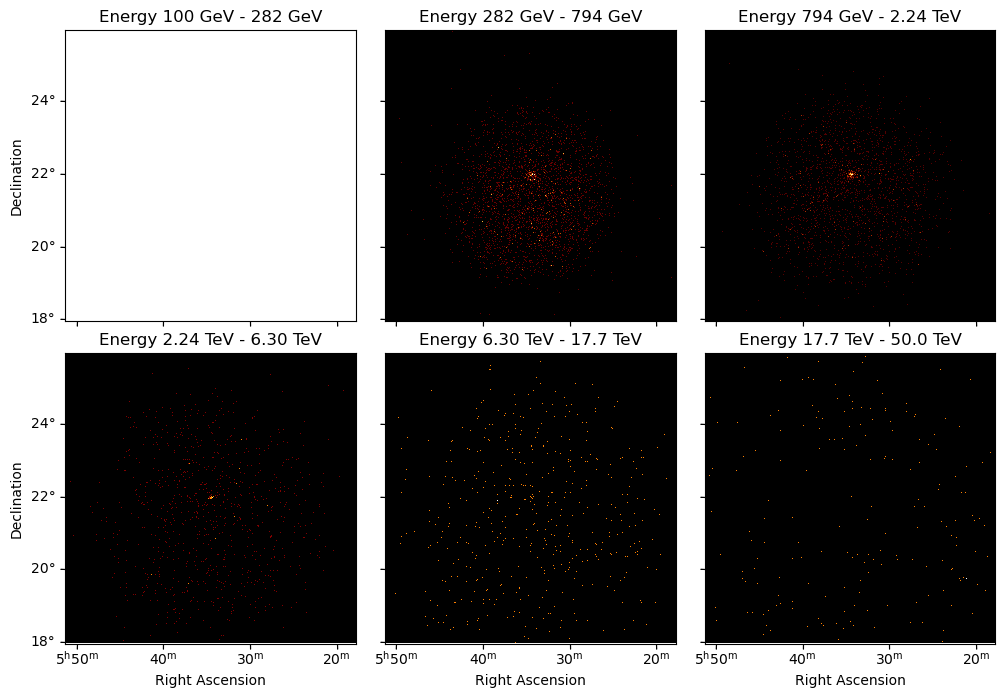

In [33]:
map_dataset.counts.plot_grid()

<WCSAxes: >

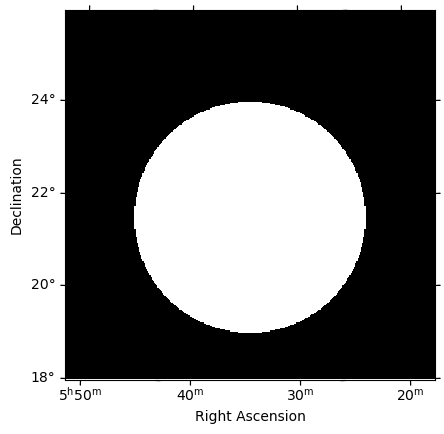

In [34]:
map_dataset.mask_image.plot()

### Ring Background
Finally we use the RingBackgroundMaker to create a background estimate. First we need an exclusion mask which flags all known and potential sources.

In [35]:
from regions import CircleSkyRegion

In [36]:
exclusion_regions = [CircleSkyRegion(center=source_pos, radius=0.4*u.deg),  ## exclude the Crab Nebula
                     CircleSkyRegion(center=SkyCoord(183.604, -8.708,       ## RGB J0521+212, recommended in gammapy tutorial
                                                     unit="deg", 
                                                     frame="galactic"),
                                     radius=0.4*u.deg)
                    ]

In [37]:
exclusion_mask = map_geom.to_image().region_mask(exclusion_regions, inside = False) 

<WCSAxes: >

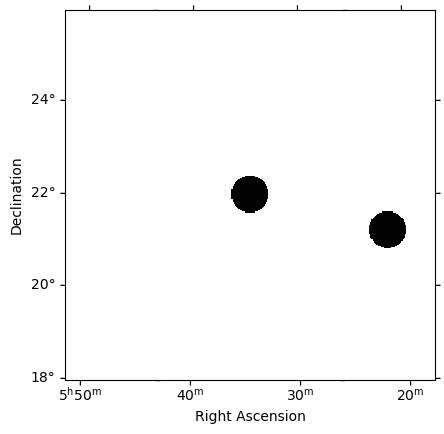

In [38]:
exclusion_mask.plot()

Now we create the RingBackgroundMaker. We can choose the inner radius of the ring, which must be larger than the largest exclusion region, and the width of the ring.

In [39]:
from gammapy.makers import RingBackgroundMaker

In [40]:
ring_bkg_maker = RingBackgroundMaker(exclusion_mask=exclusion_mask,
                                     r_in=0.4*u.deg,
                                     width=0.2*u.deg)

In [41]:
map_dataset = ring_bkg_maker.run(map_dataset)

array([[<WCSAxes: title={'center': 'Energy 100 GeV - 282 GeV'}>,
        <WCSAxes: title={'center': 'Energy 282 GeV - 794 GeV'}>,
        <WCSAxes: title={'center': 'Energy 794 GeV - 2.24 TeV'}>],
       [<WCSAxes: title={'center': 'Energy 2.24 TeV - 6.30 TeV'}>,
        <WCSAxes: title={'center': 'Energy 6.30 TeV - 17.7 TeV'}>,
        <WCSAxes: title={'center': 'Energy 17.7 TeV - 50.0 TeV'}>]],
      dtype=object)

/home/komin/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/komin/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/komin/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)


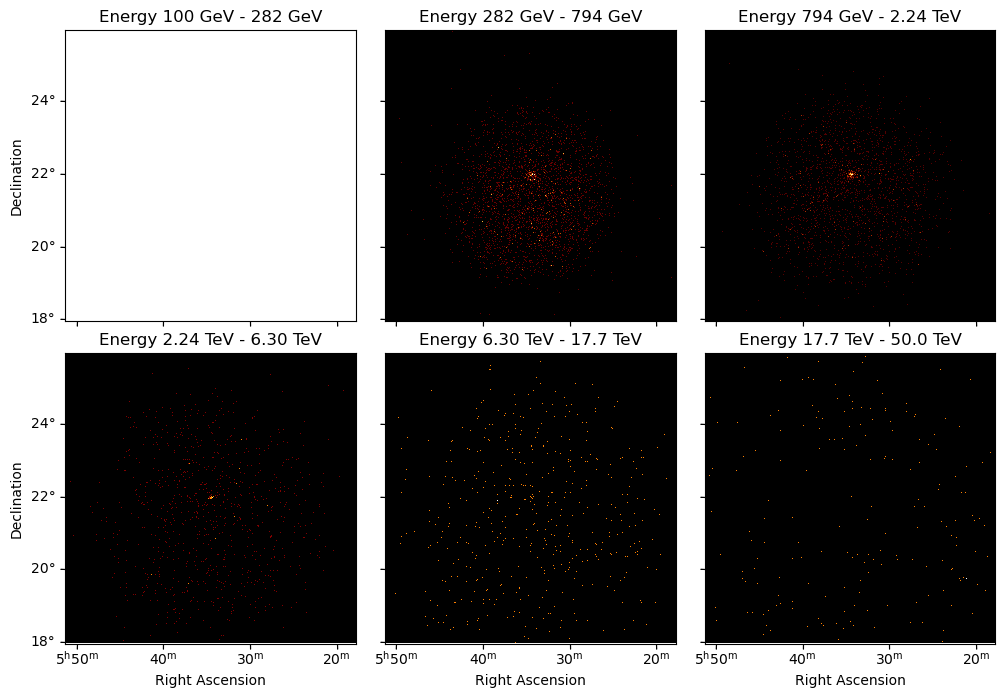

In [42]:
map_dataset.counts.plot_grid()

array([[<WCSAxes: title={'center': 'Energy 100 GeV - 282 GeV'}>,
        <WCSAxes: title={'center': 'Energy 282 GeV - 794 GeV'}>,
        <WCSAxes: title={'center': 'Energy 794 GeV - 2.24 TeV'}>],
       [<WCSAxes: title={'center': 'Energy 2.24 TeV - 6.30 TeV'}>,
        <WCSAxes: title={'center': 'Energy 6.30 TeV - 17.7 TeV'}>,
        <WCSAxes: title={'center': 'Energy 17.7 TeV - 50.0 TeV'}>]],
      dtype=object)

/home/komin/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/komin/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/komin/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)


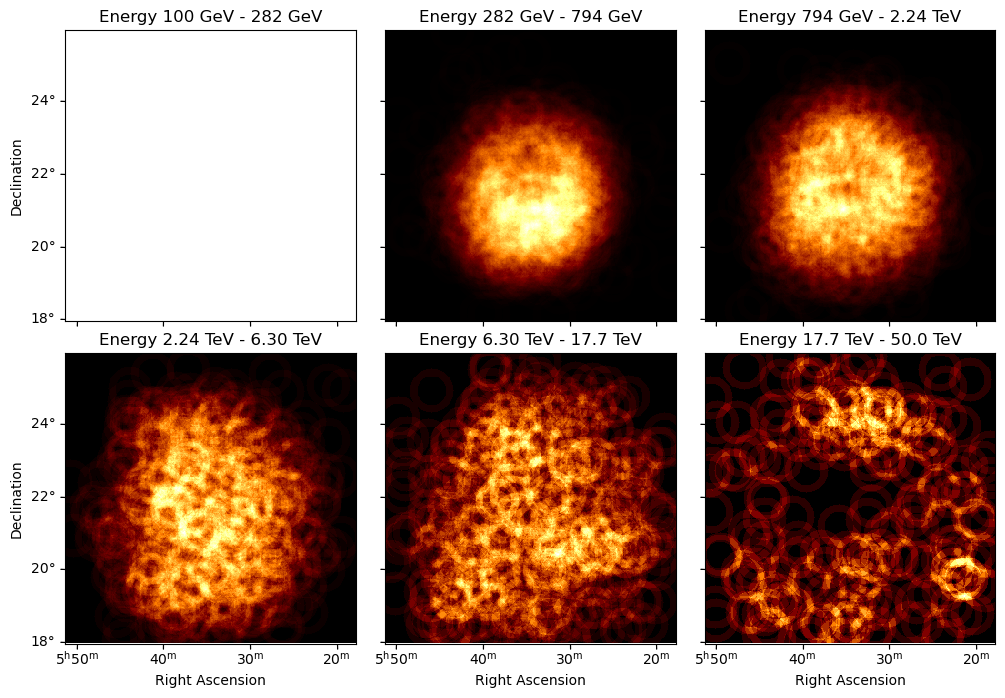

In [43]:
map_dataset.counts_off.plot_grid()

These objects can get quite large. So we need to do a bit of memory management. We delete this object as we don't need it anymore.

In [44]:
del map_dataset

### Combination of all runs
We now loop over all runs and stack the individual data sets.

In this loop we will delete the individual Datasets and keep only the stacked map.

In [45]:
from gammapy.datasets import Datasets

In [46]:
map_stacked = None

In [47]:
map_datasets = Datasets()

for obs in observations:
    map_dataset = map_maker.run(map_empty.copy(name = str(obs.obs_id)), obs)
    map_dataset = safe_mask_maker.run(map_dataset, obs)
    map_dataset = ring_bkg_maker.run(map_dataset)
    
    #map_datasets.append(map_dataset)
    
    if map_stacked is None :
        map_stacked = map_dataset.copy(name = 'map stacked')
    else :
        map_stacked.stack(map_dataset)
    
    del map_dataset

/home/komin/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/gammapy/utils/interpolation.py:185: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


In [48]:
#map_stacked = map_datasets.stack_reduce()

In [49]:
map_stacked

array([[<WCSAxes: title={'center': 'Energy 100 GeV - 282 GeV'}>,
        <WCSAxes: title={'center': 'Energy 282 GeV - 794 GeV'}>,
        <WCSAxes: title={'center': 'Energy 794 GeV - 2.24 TeV'}>],
       [<WCSAxes: title={'center': 'Energy 2.24 TeV - 6.30 TeV'}>,
        <WCSAxes: title={'center': 'Energy 6.30 TeV - 17.7 TeV'}>,
        <WCSAxes: title={'center': 'Energy 17.7 TeV - 50.0 TeV'}>]],
      dtype=object)

/home/komin/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/komin/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/komin/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)


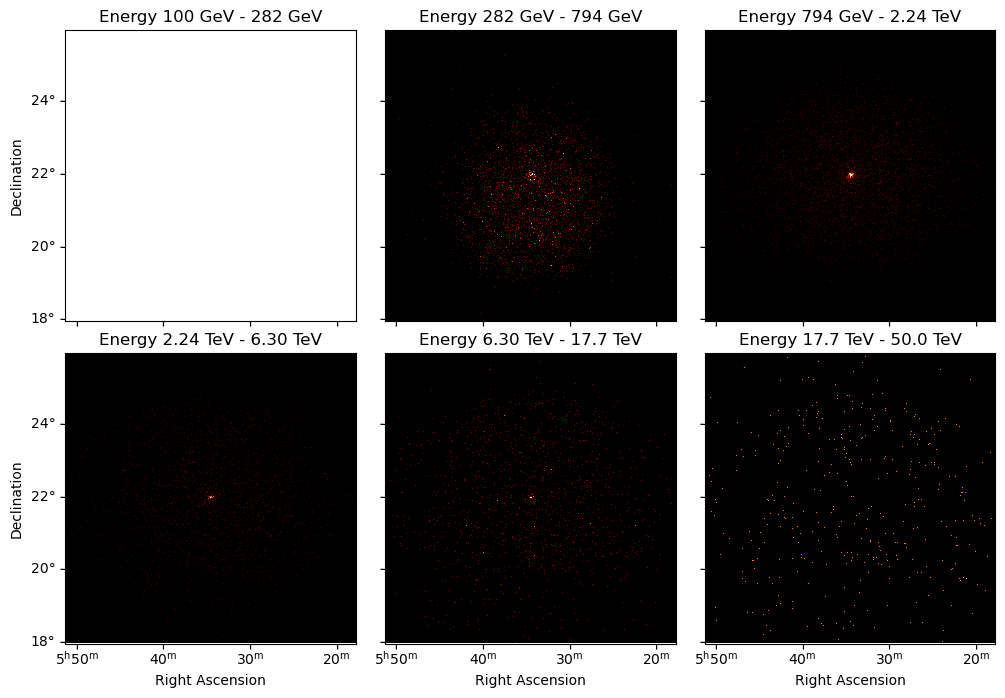

In [50]:
map_stacked.counts.plot_grid()

In [51]:
map_on = map_stacked.counts.sum_over_axes()

<WCSAxes: >

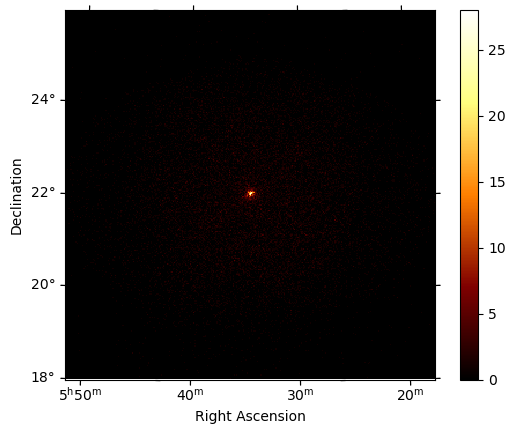

In [52]:
map_on.plot(add_cbar = True)

<WCSAxes: >

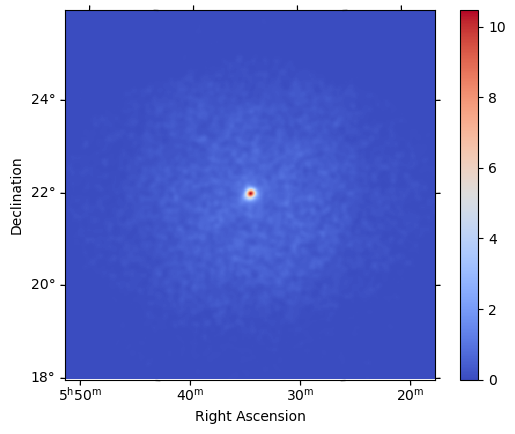

In [53]:
map_on.smooth(0.05*u.deg).plot(add_cbar = True,
                               cmap = 'coolwarm')

#plt.savefig('MapOn.svg')

array([[<WCSAxes: title={'center': 'Energy 100 GeV - 282 GeV'}>,
        <WCSAxes: title={'center': 'Energy 282 GeV - 794 GeV'}>,
        <WCSAxes: title={'center': 'Energy 794 GeV - 2.24 TeV'}>],
       [<WCSAxes: title={'center': 'Energy 2.24 TeV - 6.30 TeV'}>,
        <WCSAxes: title={'center': 'Energy 6.30 TeV - 17.7 TeV'}>,
        <WCSAxes: title={'center': 'Energy 17.7 TeV - 50.0 TeV'}>]],
      dtype=object)

/home/komin/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/komin/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/komin/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/komin/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/komin/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:17

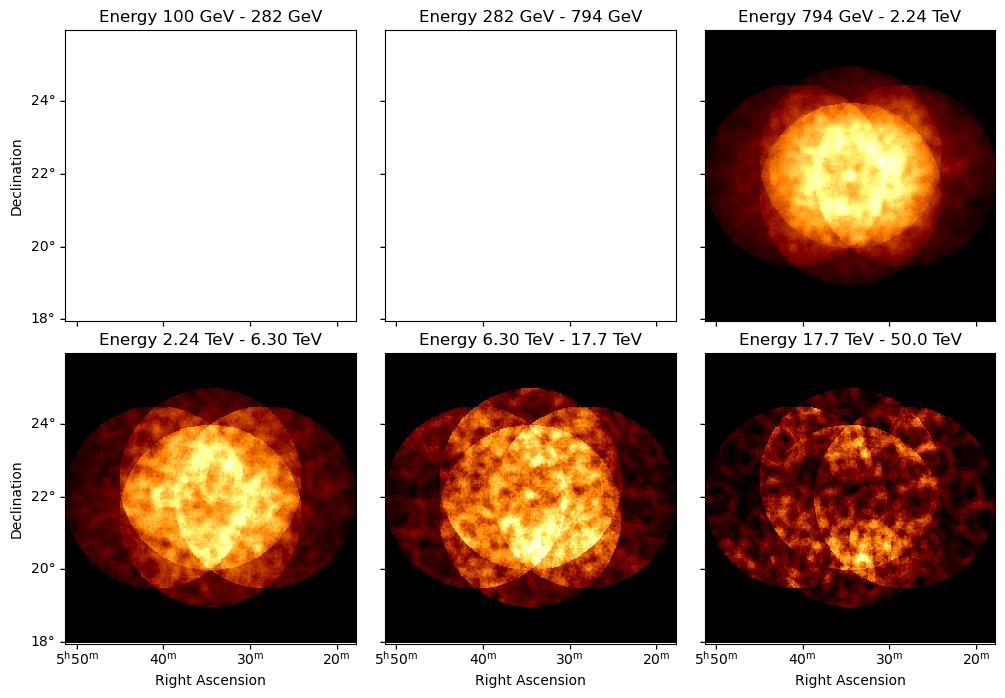

In [54]:
map_stacked.counts_off.plot_grid()

array([[<WCSAxes: title={'center': 'Energy 100 GeV - 282 GeV'}>,
        <WCSAxes: title={'center': 'Energy 282 GeV - 794 GeV'}>,
        <WCSAxes: title={'center': 'Energy 794 GeV - 2.24 TeV'}>],
       [<WCSAxes: title={'center': 'Energy 2.24 TeV - 6.30 TeV'}>,
        <WCSAxes: title={'center': 'Energy 6.30 TeV - 17.7 TeV'}>,
        <WCSAxes: title={'center': 'Energy 17.7 TeV - 50.0 TeV'}>]],
      dtype=object)

/home/komin/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/komin/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/komin/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/komin/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/komin/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:17

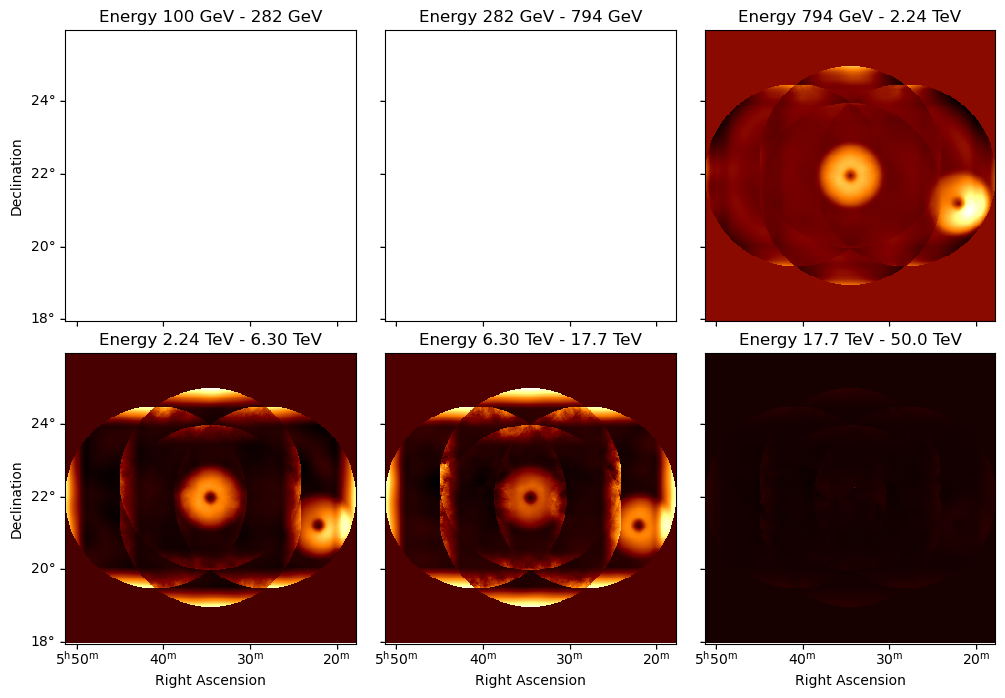

In [55]:
map_stacked.alpha.plot_grid()

In [56]:
map_off = (map_stacked.counts_off * map_stacked.alpha).sum_over_axes()

<WCSAxes: >

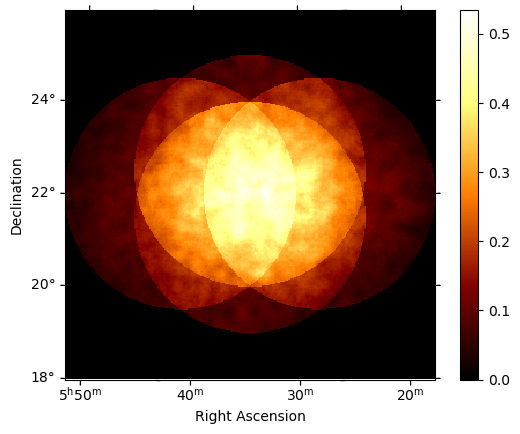

In [57]:
map_off.plot(add_cbar = True)

<WCSAxes: >

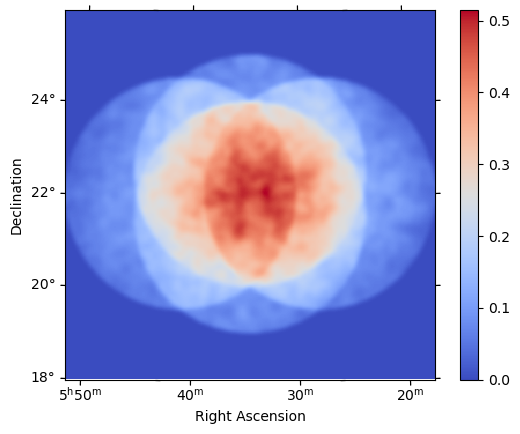

In [58]:
map_off.smooth(0.05*u.deg).plot(add_cbar = True,
                                cmap = 'coolwarm')

#plt.savefig('MapOff.svg')

In [59]:
map_excess = map_on - map_off

<WCSAxes: >

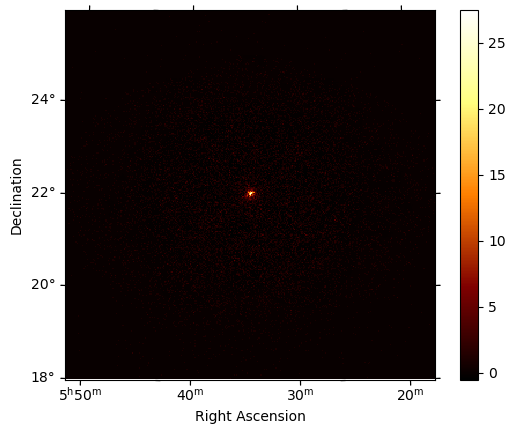

In [60]:
map_excess.plot(add_cbar = True)

<WCSAxes: >

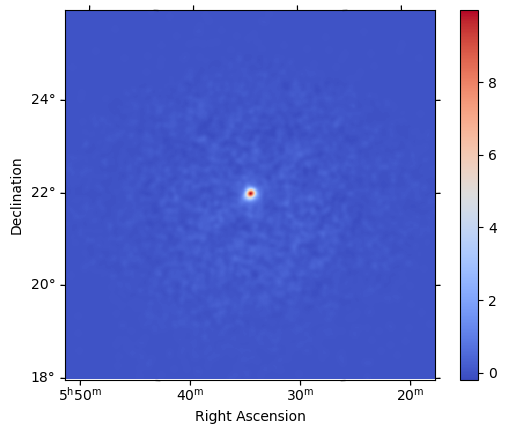

In [61]:
map_excess.smooth(0.05*u.deg).plot(add_cbar = True,
                                   cmap = 'coolwarm')

#plt.savefig('MapExcess.svg')

### Excess and Significance Maps
We could calculate the significance in each bin. There is an easy way to do that. We can use gammapy's ExcessMapEstimator.

In [62]:
from gammapy.estimators import ExcessMapEstimator

The ExcessMapEstimator uses oversampling. So we need to decide our oversampling radius. For that we should have a look at our point-spread function (PSF).

<Axes: xlabel='True Energy [$\\mathrm{TeV}$]', ylabel='Containment radius [$\\mathrm{{}^{\\circ}}$]'>

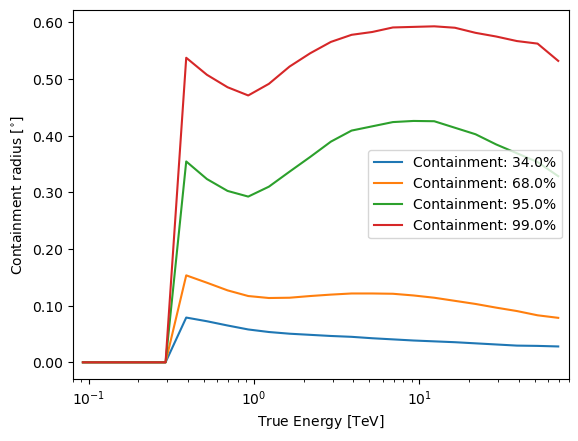

In [63]:
map_stacked.psf.plot_containment_radius_vs_energy(fraction=(0.34, 0.68, 0.95, 0.99))

The 68% radius is often a good choice. But the Crab Nebula is so bright that we can go lower than that. Let's take 0.05 deg.

In [64]:
estimator = ExcessMapEstimator(0.05*u.deg)

fluxmaps = estimator.run(map_stacked)

/home/komin/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


<WCSAxes: >

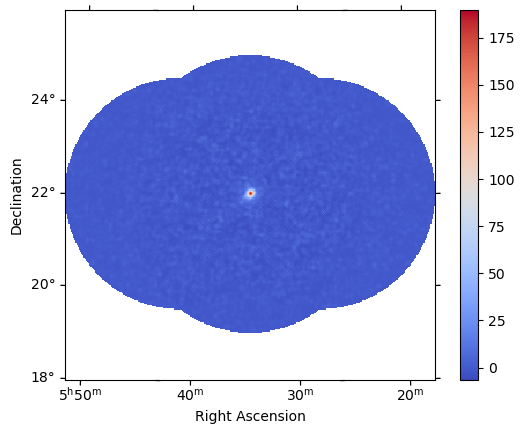

In [65]:
fluxmaps.npred_excess.plot(add_cbar = True, cmap = 'coolwarm')

#plt.savefig('FinalMap_Excess.svg')

<WCSAxes: >

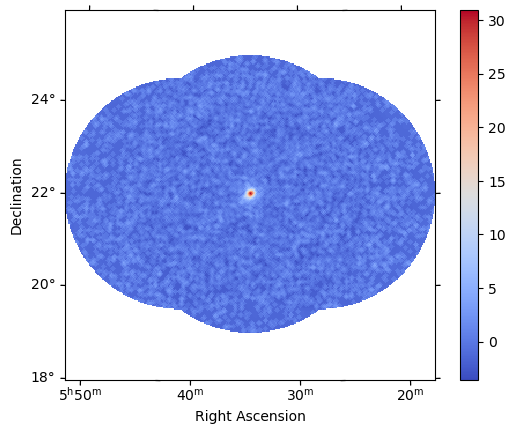

In [66]:
fluxmaps.sqrt_ts.plot(add_cbar = True, cmap = 'coolwarm')

#plt.savefig('FinalMap_Significance.svg')

<WCSAxes: >

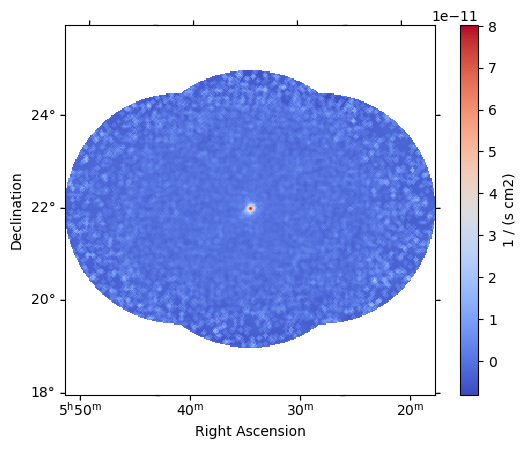

In [67]:
fluxmaps.flux.plot(add_cbar = True, cmap = 'coolwarm')

#plt.savefig('FinalMap_Flux.svg')

Let's keep the results for later.

In [68]:
final_results['excess map'] = fluxmaps.npred_excess.copy()
final_results['significance map'] = fluxmaps.sqrt_ts.copy()
final_results['flux map'] = fluxmaps.flux.copy()

#### your playground
Please try different convolution radii. You will see that smaller radii will lead to a more noisy image and larger radii will make the source appear bigger. This does not mean that the source is indeed bigger. You just smear out the emission over a larger area.

In [69]:
## your code here

### Evaluation of the Sky Map
We need to check that our background estimate is reasonable and we would like to know if there are any other potential sources in the map.

We will make a histogram of the significance distribution. This will require some data manipulation.v We will make use of numpy, which is typically imported as np.

In [70]:
import numpy as np

In [71]:
sigmapdata = final_results['significance map'].data

In [72]:
sigmapdata

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])

Let's remove anything that is not a number.

In [73]:
np.isfinite(sigmapdata)

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])

In [74]:
sigmapdata[np.isfinite(sigmapdata)]

array([-1.01695675, -1.09308957, -1.15621391, ...,  0.02288794,
       -1.3103654 , -1.21491942])

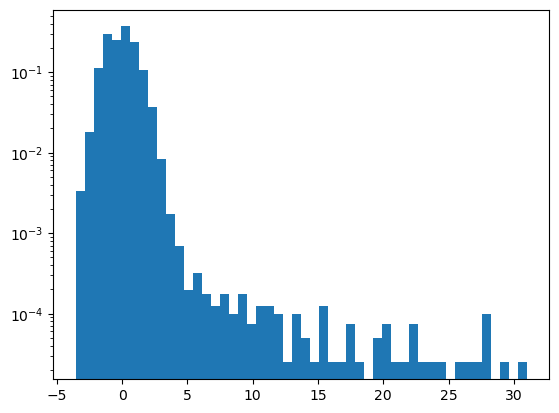

In [75]:
sig_hist = plt.hist(sigmapdata[np.isfinite(sigmapdata)],
                    bins = 50,
                    density = True,
                    color = 'tab:blue'
                   )

plt.yscale('log')

#plt.savefig('SigDist_all.svg')

We clearly see that there are bins with significances up to 30 sigma (this is the Crab Nebula). We also many bins with significances around 0 (this is in the parts of the image with no source, which is our baclground). We can also study the regions containing only background, we need to multiply the significance image with the exclusion mask. 

In [76]:
sig_off = final_results['significance map'].reduce_over_axes()*exclusion_mask

<WCSAxes: >

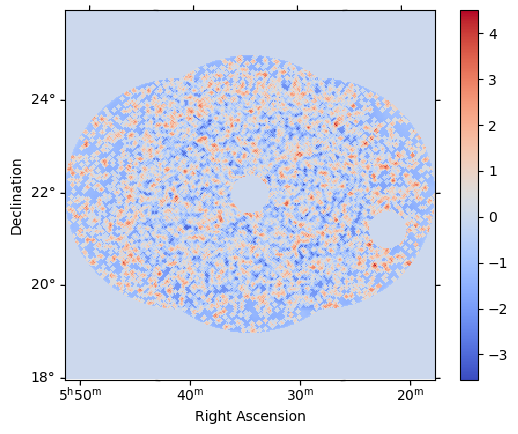

In [77]:
sig_off.plot(add_cbar = True,
             cmap = 'coolwarm'
            )

#plt.savefig('SigMap_masked.svg')

In [78]:
sigmapdata_off = sig_off.data[np.isfinite(sig_off.data)]

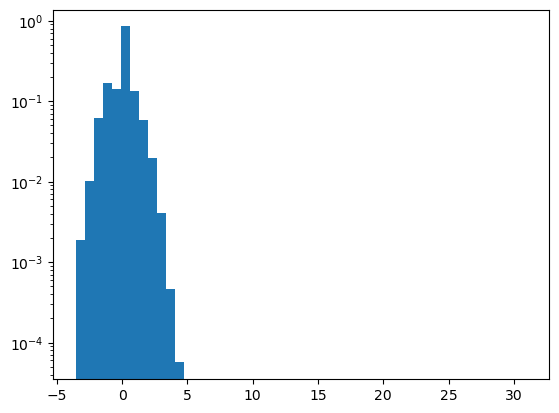

In [79]:
sig_hist_off = plt.hist(sigmapdata_off,
                        bins = sig_hist[1],
                        density = True
                       )

plt.yscale('log')

This should be a Gaussian centred on 0 with a width of 1. Let's test it.

In [80]:
from scipy.stats import norm

In [81]:
mu, std = norm.fit(sigmapdata_off)

print(f'Fit results: mu = {mu:.2f}, std = {std:.2f}')

Fit results: mu = -0.05, std = 0.81


In [82]:
x = np.linspace(-5, 5, 50)
p = norm.pdf(x, mu, std)

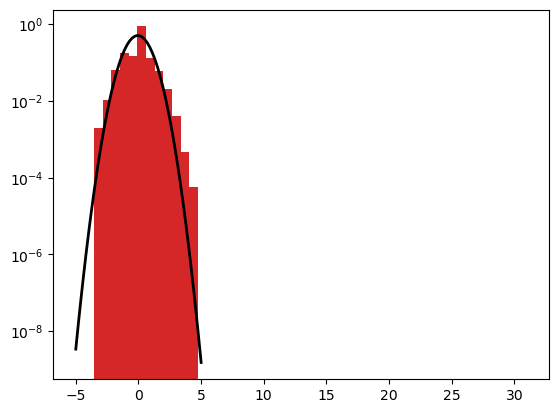

In [83]:
plt.stairs(sig_hist_off[0], sig_hist_off[1],
           fill = True,
           color = 'tab:red'
          )

plt.plot(x, p, lw=2, color="black")

plt.yscale('log')

#plt.savefig('SigDist_off.svg')

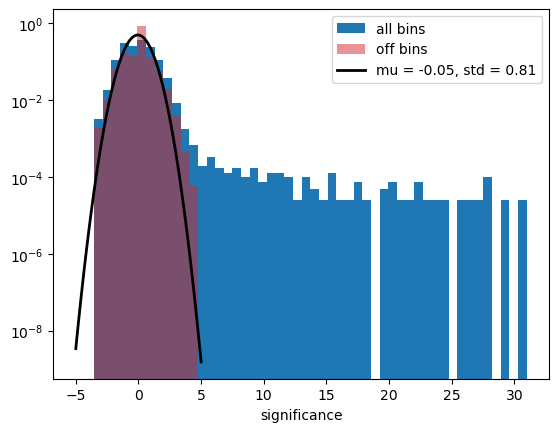

In [84]:
plt.stairs(sig_hist[0], sig_hist[1],
           fill = True,
           color = 'tab:blue',
           label='all bins'
          )

plt.stairs(sig_hist_off[0], sig_hist_off[1],
           fill = True,
           color = 'tab:red',
           label = 'off bins',
           alpha = 0.5
          )

plt.plot(x, p, lw=2, color="black", 
         label = f'mu = {mu:.2f}, std = {std:.2f}')

plt.yscale('log')

plt.xlabel('significance')

plt.legend()

#plt.savefig('SigDist_final.svg')

## Energy Spectrum
We now want to study the energy distribution of the emission from our object.

Remember that we plotted the energy distribution of all the events in one observation run:

<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Counts'>

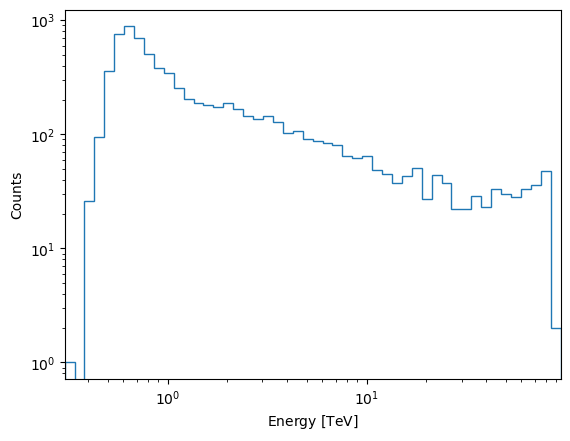

In [85]:
obs.events.plot_energy()

#plt.savefig('Counts_vs_Energy.svg')

These event counts were recorded within a certain observation time. We need to divide the counts by the time to get a rate (counts per second).

In [86]:
obs.obs_info['LIVETIME']  ## observation time in seconds

1581.2646484375

But we want to measure a flux. So we still need to divide by the effective area of the instrument. The effective area depends on the energy, but also on the conditions of the observations (like the distance of the source from the camera centre).

(0.4, 99.99999999999994)

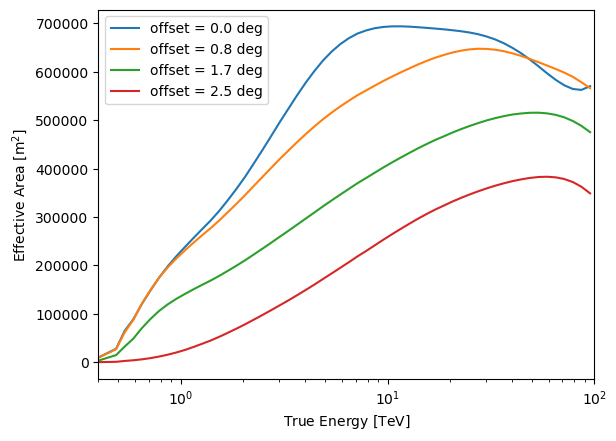

In [87]:
obs.aeff.plot_energy_dependence()

plt.xlim(0.4)

#plt.savefig('Aeff.svg')

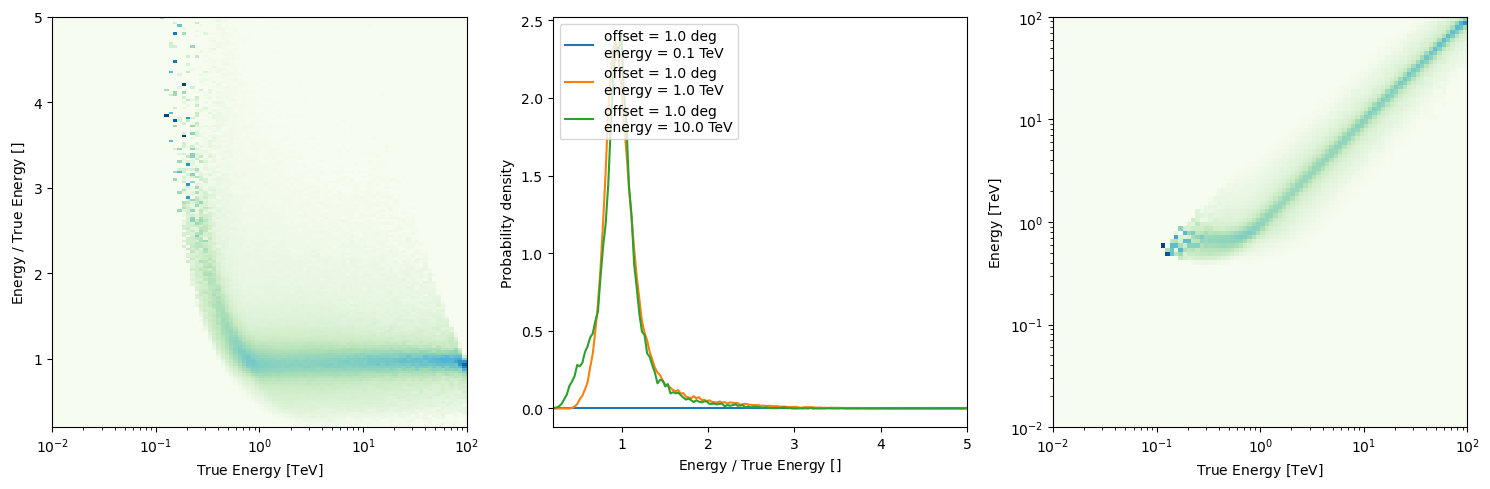

In [88]:
obs.edisp.peek()

<Axes: xlabel='True Energy [$\\mathrm{TeV}$]', ylabel='Energy [$\\mathrm{TeV}$]'>

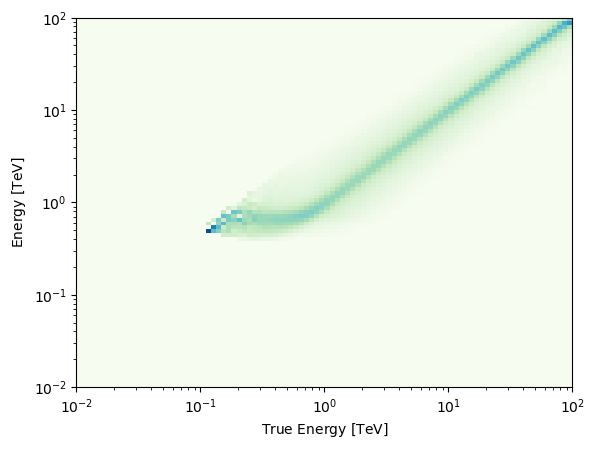

In [89]:
obs.edisp.to_edisp_kernel(0.7*u.deg).plot_matrix()

#plt.savefig('EDisp.svg')

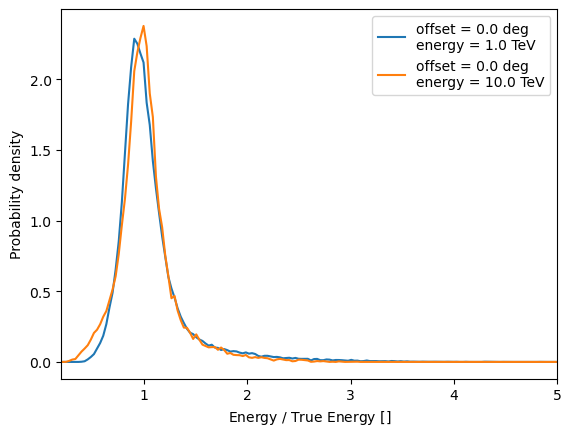

In [90]:
obs.edisp.plot_migration(offset = 0*u.deg, energy_true = [1,10]*u.TeV)

plt.legend(loc='upper right')

#plt.savefig('Eresolution.svg')

### SpectrumDatasetMaker
We will now use gammapy code to do the binning of our event lists. This is very similar to the generation of the MapDataset.

In [91]:
from gammapy.datasets import SpectrumDataset

from gammapy.makers import SpectrumDatasetMaker

We want to use only the events from a small region around the source, the on region. We start with a region at the source position and with a radius of 0.1 degrees. We can change that later if needed.

In [92]:
on_region_radius = Angle(0.1*u.deg)

on_region = CircleSkyRegion(center=source_pos, radius=on_region_radius)

We can check on the sky map if the region really encompasses all of the emission. If not, we we need to increase the size. We will use a zoomed version of the significance map.

In [93]:
skymap = final_results['significance map'].cutout(source_pos, 1*u.deg)

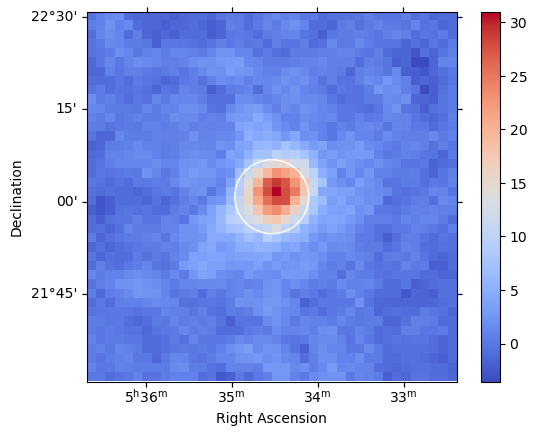

In [94]:
skymap.plot(add_cbar = True, cmap = 'coolwarm')

on_region.to_pixel(skymap.geom.wcs).plot(color = 'white')

In [95]:
Emin, Emax

(<Quantity 0.1 TeV>, <Quantity 50. TeV>)

In [96]:
spectrum_nEbins = 20

spectrum_energy_axis = MapAxis.from_energy_bounds(Emin, Emax,
                                                  nbin=spectrum_nEbins,
                                                  name="energy")

In [97]:
from gammapy.maps import RegionGeom

In [98]:
spectrum_geom = RegionGeom.create(region=on_region, 
                                  axes=[spectrum_energy_axis]
                                 )

In [99]:
spectrum_empty =  SpectrumDataset.create(geom=spectrum_geom, 
                                         energy_axis_true=energy_axis_true
                                        )

In [100]:
from gammapy.makers import SpectrumDatasetMaker

In [101]:
spectrum_maker = SpectrumDatasetMaker()

In [102]:
spectrum_dataset = spectrum_maker.run(spectrum_empty, obs)

<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='$\\mathrm{}$'>

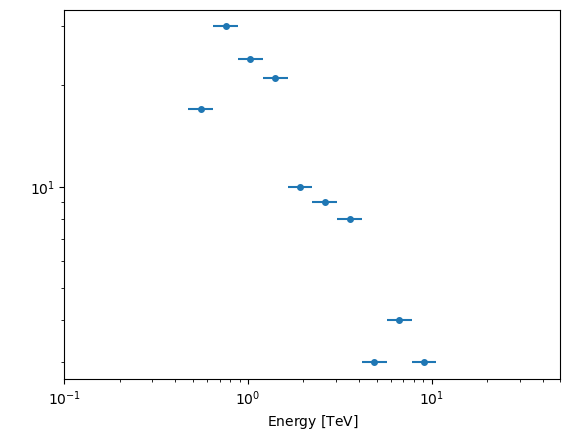

In [103]:
spectrum_dataset.counts.plot()

In [104]:
#spectrum_dataset.counts_off.plot()

<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='$\\mathrm{}$'>

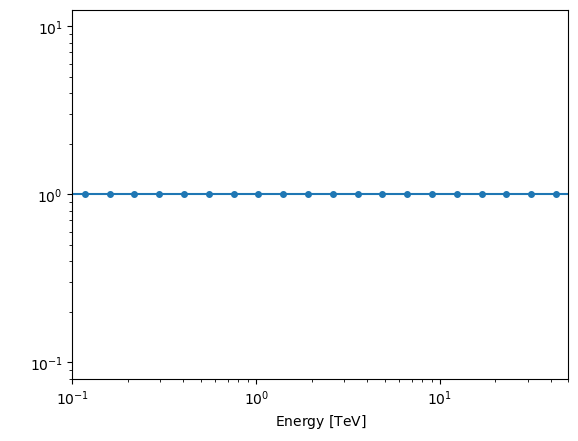

In [105]:
spectrum_dataset.mask.plot()

### SafeMaskMaker
As before, we need to select the good energy and offset range. We will use the same SafeMaskMaker as before.

In [106]:
spectrum_dataset = safe_mask_maker.run(spectrum_dataset, obs)

<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='$\\mathrm{}$'>

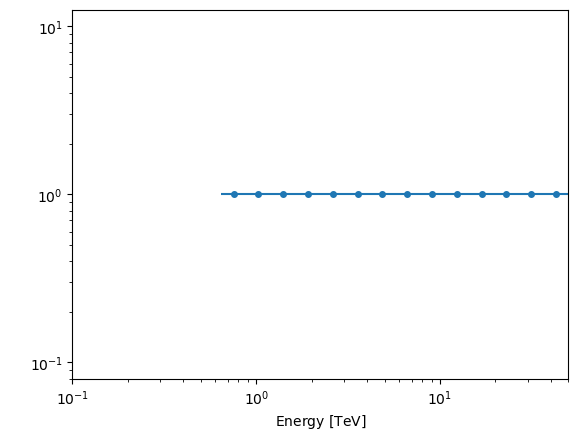

In [107]:
spectrum_dataset.mask.plot()

In [108]:
spectrum_dataset.energy_range_total

(<Quantity 0.64519501 TeV>, <Quantity 50. TeV>)

In this run we will use only events with energies of more than 645 GeV.

### Reflected Background
We will use the reflected background to estimate the off source counts. We will need an exclusion mask, we will use the same as before.

In [109]:
from gammapy.makers import ReflectedRegionsBackgroundMaker

In [110]:
reflected_bkg_maker = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)

In [111]:
spectrum_dataset = reflected_bkg_maker.run(spectrum_dataset, obs)

<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='$\\mathrm{}$'>

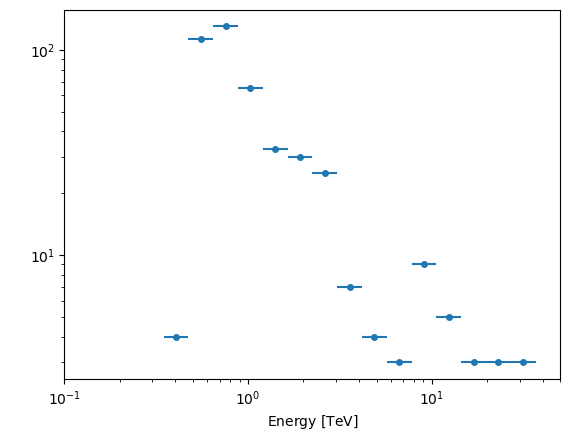

In [112]:
spectrum_dataset.counts_off.plot()

We can check on the sky map the location of our off-source regions.

In [113]:
from gammapy.visualization import plot_spectrum_datasets_off_regions

AttributeError: 'Datasets' object has no attribute 'counts_off'

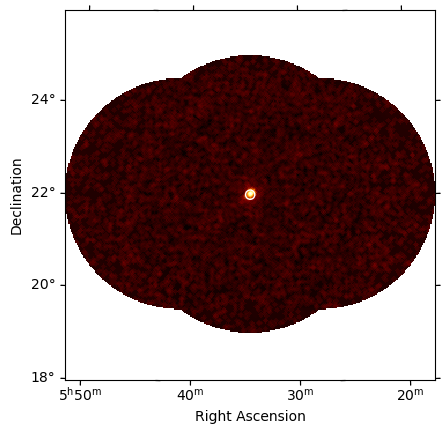

In [ ]:
skymap = final_results['significance map']

ax = skymap.plot()

on_region.to_pixel(skymap.geom.wcs).plot(color = 'white')

plot_spectrum_datasets_off_regions(ax=ax, datasets=[spectrum_datasets])

### Combination of all runs
We now loop over all runs and stack the individual data sets.

In [115]:
%%time

spectrum_datasets = Datasets()

for obs in observations:
    spectrum_dataset = spectrum_maker.run(spectrum_empty.copy(name = str(obs.obs_id)), obs)
    spectrum_dataset = safe_mask_maker.run(spectrum_dataset, obs)
    spectrum_dataset = reflected_bkg_maker.run(spectrum_dataset, obs)
    
    spectrum_datasets.append(spectrum_dataset)

CPU times: user 2.88 s, sys: 45.7 ms, total: 2.93 s
Wall time: 2.9 s


In [116]:
spectrum_stacked = spectrum_datasets.stack_reduce()

/home/komin/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/regions/shapes/circle.py:161: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Circle(xy=xy, radius=radius, **mpl_kwargs)
/home/komin/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/gammapy/visualization/datasets.py:84: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handle = Patch(**plot_kwargs)


<WCSAxes: >

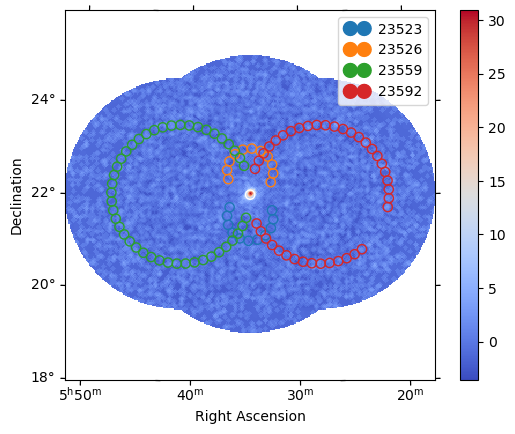

In [117]:
ax = skymap.plot(cmap = 'coolwarm', add_cbar = True)

on_region.to_pixel(skymap.geom.wcs).plot(color = 'white')

plot_spectrum_datasets_off_regions(ax=ax, datasets=spectrum_datasets)

#plt.savefig('ReflectedRegions.svg')

### Excess and Significance
We can now use the SpectrumDatasets to study the excess and the significance of the source.

In [118]:
info_table = spectrum_datasets.info_table()

In [119]:
info_table.colnames

['name',
 'counts',
 'excess',
 'sqrt_ts',
 'background',
 'npred',
 'npred_background',
 'npred_signal',
 'exposure_min',
 'exposure_max',
 'livetime',
 'ontime',
 'counts_rate',
 'background_rate',
 'excess_rate',
 'n_bins',
 'n_fit_bins',
 'stat_type',
 'stat_sum',
 'counts_off',
 'acceptance',
 'acceptance_off',
 'alpha']

In [120]:
info_table['name', 'counts', 'counts_off', 'alpha', 'excess', 'sqrt_ts']

name,counts,counts_off,alpha,excess,sqrt_ts
str5,int64,int64,float64,float64,float64
23523,152,116,0.09090909361839294,141.4545440673828,20.221815803446926
23526,174,148,0.09090909090909093,160.54545454545453,21.123867154131364
23559,115,230,0.022727272727272724,109.77272727272728,21.134689735496472
23592,112,320,0.02564102564102564,103.7948717948718,18.65641635112894


In [121]:
#info_table['name', 'counts', 'counts_off', 'alpha', 'excess', 'sqrt_ts'].write('info_table.csv')

In [122]:
sum_table = spectrum_datasets.info_table(cumulative=True)

In [123]:
sum_table['name', 'counts', 'counts_off', 'alpha', 'excess', 'sqrt_ts']

name,counts,counts_off,alpha,excess,sqrt_ts
str7,int64,int64,float64,float64,float64
stacked,152,116,0.09090909361839294,141.4545440673828,20.221815803446926
stacked,326,264,0.09090910851955414,302.0,29.235503433827606
stacked,441,494,0.059164516627788544,411.7727355957031,36.167736845212374
stacked,553,814,0.04598575085401535,515.567626953125,41.03459393663848


In [124]:
#sum_table['name', 'counts', 'counts_off', 'alpha', 'excess', 'sqrt_ts'].write('sum_table.csv')

The last line gives us the on and off counts, as well as excess and significance.

In [125]:
last_line = sum_table[-1]

In [126]:
last_line['name', 'counts', 'counts_off', 'alpha', 'excess', 'sqrt_ts']

name,counts,counts_off,alpha,excess,sqrt_ts
str7,int64,int64,float64,float64,float64
stacked,553,814,0.04598575085401535,515.567626953125,41.03459393663848


In [127]:
last_line['counts'] - last_line['alpha'] * last_line['counts_off']

515.5675988048315

In [128]:
stat = WStatCountsStatistic(n_on=last_line['counts'], 
                            n_off=last_line['counts_off'], 
                            alpha=last_line['alpha']
                           )

print('excess: {} \nsignificance: {}'.format(stat.n_sig,stat.sqrt_ts))

excess: 515.5675988048315 
significance: 41.03459393663848


Let's keep these results for later.

In [129]:
final_results['excess'] = sum_table[-1]['excess']
final_results['significance'] = sum_table[-1]['sqrt_ts']

The excess should increase roughly linearly with time:

Text(0, 0.5, 'Excess')

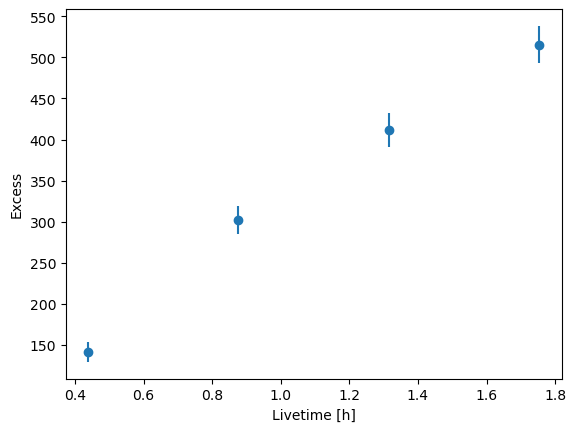

In [130]:
plt.errorbar(sum_table['livetime'].to(u.h),
             sum_table['excess'],
             np.sqrt(sum_table['excess']),
             marker='o',
             ls='none'
            )

plt.xlabel('Livetime [h]')
plt.ylabel('Excess')

#plt.savefig('ExcessVsT.svg')

Text(0, 0.5, 'Significance')

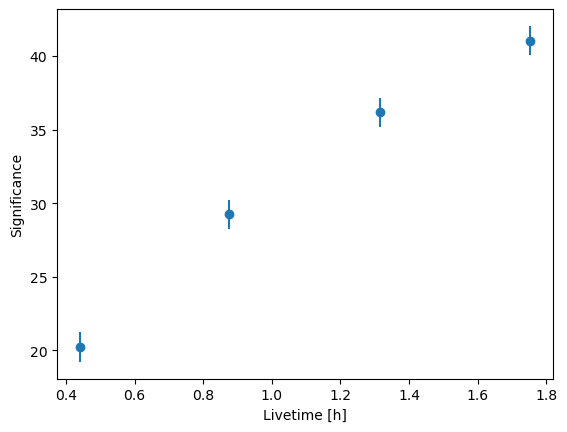

In [131]:
plt.errorbar(sum_table['livetime'].to(u.h),
             sum_table['sqrt_ts'],
             1,
             marker='o',
             ls='none'
            )

plt.xlabel('Livetime [h]')
plt.ylabel('Significance')

#plt.savefig('SigVsT.svg')

### Excess and Flux

We can subtract the off-source counts from the on-source counts to get the excess:

<Axes: xlabel='Energy [$\\mathrm{TeV}$]'>

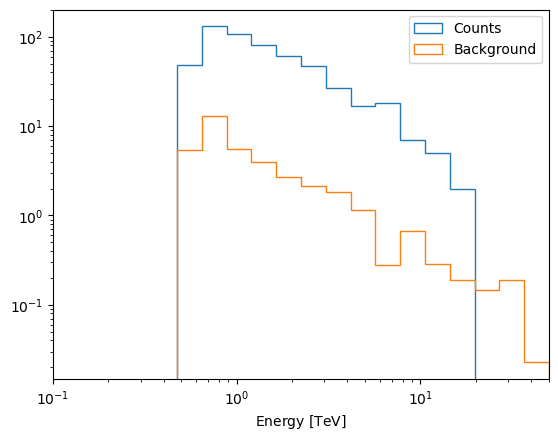

In [132]:
spectrum_stacked.plot_counts()

#plt.savefig('Spectrum_OnOffCounts.svg')

As usual, we can use (on - alpha*off) to calculate the excess:

In [133]:
excess = spectrum_stacked.counts.data - spectrum_stacked.counts_off.data * spectrum_stacked.alpha.data

In [134]:
excess = excess.reshape(excess.shape[0])

In [135]:
spectrum_stacked.geoms['geom'].axes['energy'].center

<Quantity [ 0.11680845,  0.15937594,  0.21745593,  0.29670151,  0.40482586,
            0.55235304,  0.75364227,  1.02828559,  1.4030148 ,  1.91430332,
            2.61191628,  3.56375428,  4.86246236,  6.63444737,  9.0521815 ,
           12.35098952, 16.85195356, 22.99316489, 31.37236463, 42.80512348] TeV>

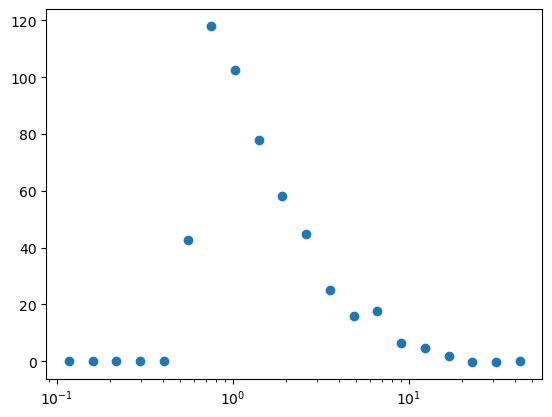

In [136]:
plt.plot(spectrum_stacked.geoms['geom'].axes['energy'].center,
         excess,
         marker = 'o',
         ls = 'none'
        )

plt.xscale('log')

<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='$\\mathrm{}$'>

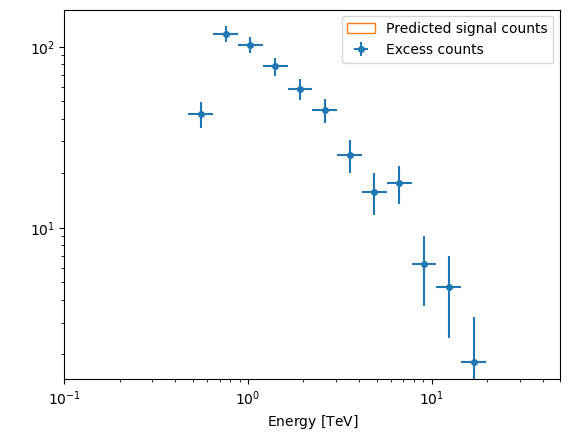

In [137]:
spectrum_stacked.plot_excess()

#plt.savefig('Spectrum_ExcessCounts.svg')

We could divide the excess by the exposure to get a flux:

<Axes: xlabel='True Energy [$\\mathrm{TeV}$]', ylabel='$\\mathrm{m^{2}\\,s}$'>

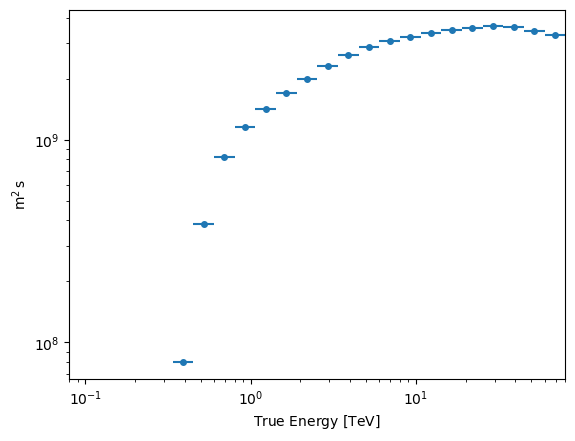

In [138]:
spectrum_stacked.exposure.plot()

#plt.savefig('Spectrum_Exposure.svg')

But the binning is different and the exposure is in true energy. So we need to apply the energy dispersion matrix and to interpolate. We don't need to do that by hand.

In [139]:
if False :

    flux = spectrum_dataset.excess.quantity / spectrum_dataset.exposure.quantity

    plt.plot(spectrum_stacked.geoms['geom'].axes['energy'].center,
             flux.reshape(20),
             marker = 'o',
             ls = 'none'
            )

    plt.xlabel('E [{}]'.format(spectrum_stacked.geoms['geom'].axes['energy'].center.unit))
    plt.ylabel('flux [{}]'.format(flux.unit))

    plt.xscale('log')
    plt.yscale('log')

    #plt.savefig('SimpleFlux.svg')

### Spectrum Fit
Now we want to describe the energy distribution of the gamma rays with a function. We will make a spectral fit. We will stack all the data of all runs into one data set and proceed with the fit. We could also fit the model to each run individually.

We start with a simple power law. Remember, the power law is
$$
f(E) = A \times \left( \frac{E}{E_0} \right) ^{-\Gamma}.
$$
The amplitude $A$ and the spectral index $\Gamma$ are free parameters in the fit. $E_0$ is the reference energy, which is not fitted. You can freely chose the value of $E_0$, but it is best to keep it within the energy range of the data.

In [140]:
from gammapy.modeling.models import PowerLawSpectralModel, SkyModel

In [141]:
spectral_model = PowerLawSpectralModel(index=2, 
                                       amplitude=1e-11 * u.Unit("cm-2 s-1 TeV-1"), 
                                       reference=1 * u.TeV
                                      )

We set the spectral model to a power law with some meaningful start parameters. The spectral model is only a part of a more general model, the SkyModel, which can also contain a spatial and a temporal model.

In [142]:
model = SkyModel(spectral_model=spectral_model, name="Crab")

Next we set this model as the model of our Dataset. We can also have a look how well our start parameters describe the data already:

In [143]:
spectrum_dataset.models = model

(0.1, 44.50537437229409)

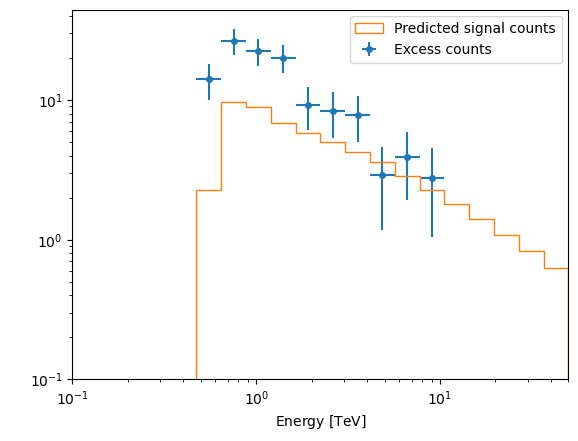

In [144]:
spectrum_dataset.plot_excess()

plt.ylim(1e-1)

To do the fit we use a gammapy object called Fit. We can reuse the same object later, we need to create it only once.

In [145]:
from gammapy.modeling import Fit

In [146]:
fit = Fit()

Now we run the fit of our Dataset.

In [147]:
fit.run(spectrum_dataset)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully..
	nfev       : 53
	total stat : 10.89

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

It is very important to check the output. Success must be True and everything has to terminate succesfully. Otherwise our fit result is wrong. If the fit fails, try to run it again. Or change the start parameters and run again. Do not continue with a failed fit!

We can now take a look at our result and the fit parameters:

(0.1, 40)

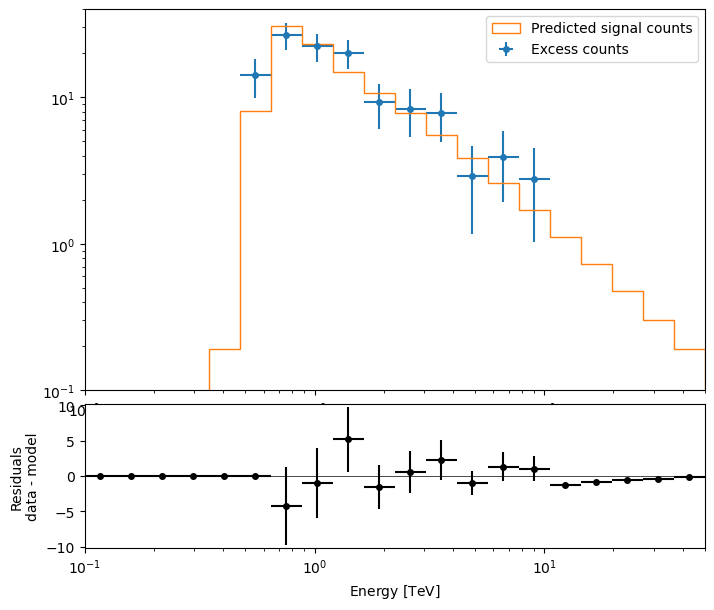

In [148]:
ax_spectrum, ax_residuals = spectrum_dataset.plot_fit()

ax_spectrum.set_ylim(0.1, 40)

#plt.savefig('PLfit.svg')

In [149]:
spectrum_dataset.models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str4,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
Crab,spectral,index,2.5872e+00,,1.365e-01,nan,nan,False,False,
Crab,spectral,amplitude,2.6369e-11,TeV-1 s-1 cm-2,2.944e-12,nan,nan,False,True,
Crab,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,


We will make a copy of the model for later use:

In [150]:
bestmodel_PL = spectrum_dataset.models.copy()

In [151]:
from gammapy.modeling.models import create_crab_spectral_model

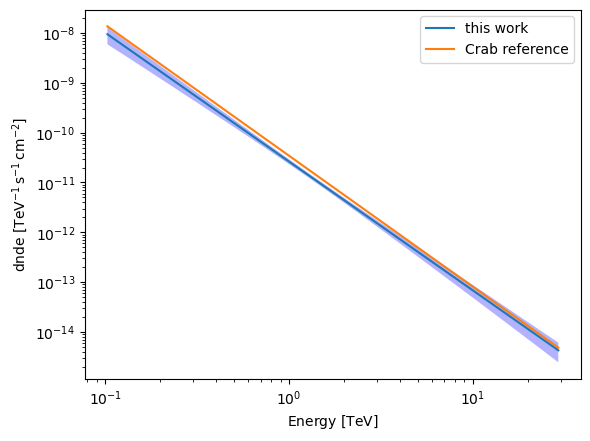

In [152]:
fig, ax = plt.subplots()

plot_kwargs = {
    "energy_bounds": [0.1, 30] * u.TeV,
    "ax": ax,
}

bestmodel_PL[0].spectral_model.plot(**plot_kwargs, label="this work")
bestmodel_PL[0].spectral_model.plot_error(facecolor="blue", alpha=0.3, **plot_kwargs)

create_crab_spectral_model("hess_pl").plot(
    **plot_kwargs,
    label="Crab reference",
)

ax.legend()

#plt.savefig('PLmodel.svg')

We will also compare this model with a different model. In order to decide which model to be used we will save the test statistics.

In [153]:
TS_PL = spectrum_dataset.stat_sum()

In [154]:
TS_PL

10.888094127483972

Let's do the spectrum again, this time we want to fit a power law with an exponential cut-off at high energies. This function is defined as
$$
f(E) = A \times \left( \frac{E}{E_0} \right)^{-\Gamma} \times \exp \left(-\frac{E}{E_c} \right).
$$
The last term can be written as
$$
\exp \left(-\frac{E}{E_c} \right) = \exp \left(-\lambda E \right)
$$
with $\lambda = 1/E_c$.

Here it is a good idea to use our best fit parameters from the power law as starting parameters.

In [155]:
from gammapy.modeling.models import ExpCutoffPowerLawSpectralModel

In [156]:
bestmodel_PL.parameters['index'].quantity

<Quantity 2.58715886>

In [157]:
bestmodel_PL.parameters['amplitude'].quantity

<Quantity 2.63688054e-11 1 / (TeV s cm2)>

In [158]:
spectral_model = ExpCutoffPowerLawSpectralModel(index=bestmodel_PL.parameters['index'].quantity, 
                                                amplitude=bestmodel_PL.parameters['amplitude'].quantity, 
                                                reference=1 * u.TeV, 
                                                lambda_ = 1./(10*u.TeV)
                                               )

model = SkyModel(spectral_model=spectral_model, name="Crab")

spectrum_dataset.models = model

(0.1, 49.23998307179096)

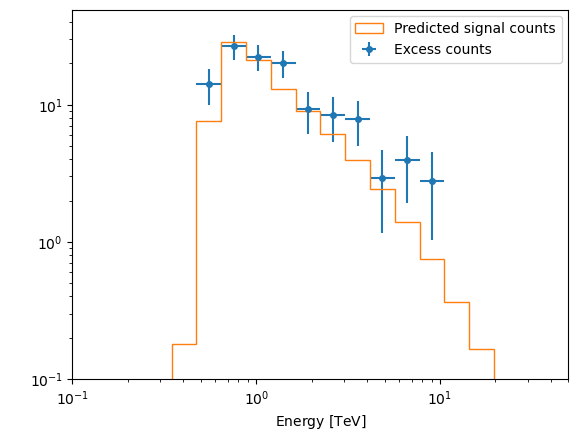

In [159]:
spectrum_dataset.plot_excess()

plt.ylim(1e-1)

In [160]:
fit.run(spectrum_dataset)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully..
	nfev       : 74
	total stat : 6.81

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

Don't forget to check for success!

(0.1, 40)

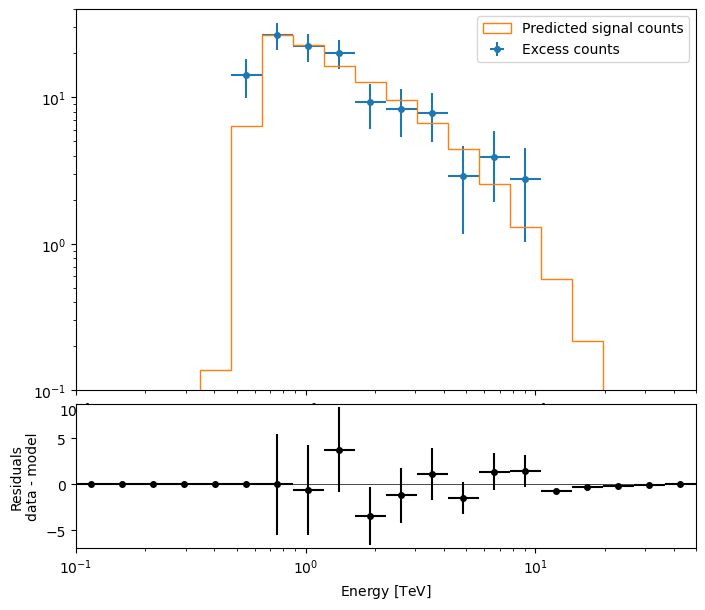

In [161]:
ax_spectrum, ax_residuals = spectrum_dataset.plot_fit()

ax_spectrum.set_ylim(0.1, 40)

#plt.savefig('ExpPLfit.svg')

In [162]:
spectrum_dataset.models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str4,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
Crab,spectral,index,1.9763e+00,,3.945e-01,nan,nan,False,False,
Crab,spectral,amplitude,3.2444e-11,TeV-1 s-1 cm-2,6.222e-12,nan,nan,False,True,
Crab,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
Crab,spectral,lambda_,2.1086e-01,TeV-1,1.484e-01,nan,nan,False,False,
Crab,spectral,alpha,1.0000e+00,,0.000e+00,nan,nan,True,False,


In [163]:
bestmodel_expPL = spectrum_dataset.models.copy()

What is the best-fit cut-off energy?

In [164]:
1/(bestmodel_expPL.parameters['lambda_'].quantity)

<Quantity 4.74245034 TeV>

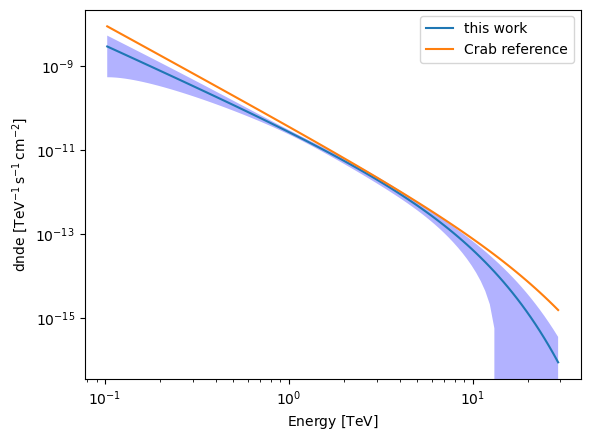

In [165]:
fig, ax = plt.subplots()

plot_kwargs = {
    "energy_bounds": [0.1, 30] * u.TeV,
    "ax": ax,
}

bestmodel_expPL[0].spectral_model.plot(**plot_kwargs, label="this work")
bestmodel_expPL[0].spectral_model.plot_error(facecolor="blue", alpha=0.3, **plot_kwargs)

create_crab_spectral_model("hess_ecpl").plot(
    **plot_kwargs,
    label="Crab reference",
)

ax.legend()

#plt.savefig('ExpPLmodel.svg')

In [166]:
TS_expPL = spectrum_dataset.stat_sum()

In [167]:
TS_expPL

6.809755599423888

### Compare the Models

Which model is better, with or without the cut-off? We will need to compare the test statistics of the fits.

In [168]:
print(TS_PL, TS_expPL)

10.888094127483972 6.809755599423888


Gammapy uses a log-likelihood fit. So we can use the likelihood and Wilk's theorem, provided that we are dealing with nested models. The TS value returned by gammapy is already 2xln(L). So only need to take the difference:

In [169]:
TS = TS_PL-TS_expPL
print(TS)

4.078338528060084


In [170]:
import scipy.stats

In [171]:
P = scipy.stats.chi2.sf(TS,1)

print('probabilty: ',P)

probabilty:  0.043436349883883646


In [172]:
print('significant?', P < 2.7e-3)

significant? False


The model with the cut-off is not significantly better. So we will use the straight power law for our further analysis.

In [173]:
bestmodel = bestmodel_PL

Let's set this model as the current model of the Dataset:

In [174]:
spectrum_dataset.models = bestmodel

And we store the fit parameters in the final results.

In [175]:
final_results['fit parameters'] = bestmodel.parameters.to_table()

final_results['model type'] = bestmodel[0].spectral_model.tag[0]

### Your playground
You can try to fit yet another model. A LogParabolaSpectralModel could work as well. Check the documentation (https://docs.gammapy.org/0.18.2/api/gammapy.modeling.models.LogParabolaSpectralModel.html#gammapy.modeling.models.LogParabolaSpectralModel) for the parameters of this model.
You can compare the log-parabola model with the power law. But you cannot use Wilk's theorem to compare it to the exponential cut-off power law, as they are not nested models.

In [176]:
## your code here

## Flux Points
In the final step we want to create flux points which can be used for later analysis and astrophysical modelling. These points will depend on our best-fit model. Let's check first that we indeed have our best-fit model.

In [177]:
spectrum_dataset.models[0].spectral_model.tag[0]

'PowerLawSpectralModel'

In [178]:
spectrum_dataset.models.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
spectral,index,2.5872e+00,,1.365e-01,nan,nan,False,False,
spectral,amplitude,2.6369e-11,TeV-1 s-1 cm-2,2.944e-12,nan,nan,False,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,


We need only flux points within our energy range:

In [179]:
spectrum_dataset.energy_range_total

(<Quantity 0.64519501 TeV>, <Quantity 50. TeV>)

We will use 10 bins.

In [180]:
energy_edges = np.geomspace(0.65, 50, 11) * u.TeV

The FluxPointsEstimator will do the analysis.

In [181]:
from gammapy.estimators import FluxPointsEstimator

In [182]:
fpe = FluxPointsEstimator(energy_edges = energy_edges,
                          selection_optional = ['ul']
                         )

In [183]:
flux_points = fpe.run(spectrum_dataset)

In [184]:
flux_points.to_table()

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,norm,norm_err,norm_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success
TeV,TeV,TeV,1 / (TeV s cm2),1 / (s cm2),TeV / (s cm2),,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,bool,float64[1],bool
0.7536422741614978,0.6451950121482162,0.8803178367920129,5.48129862230315e-11,1.2966563253222704e-11,9.687236532047296e-12,0.8634233079728916,0.17759627570299155,1.262940873697676,73.49057646538495,8.572664490424488,29.999852985426028,26.66652,7.225935405585915e-10,False,30.0,True
1.2011244339814315,0.8803178367920129,1.6388397980945055,1.6412836813068756e-11,1.2754106711447965e-11,1.479722064907867e-11,1.1118251516854143,0.1754804841635739,1.498438970543978,159.8835133825324,12.644505264443223,45.043274006699704,42.53157,1.1467473956858498,False,45.0,True
1.9143033178604023,1.6388397980945055,2.23606797749979,4.914550926970579e-12,2.9530497271928757e-12,5.603911678754652e-12,0.8565411292084404,0.29372334201968936,1.5735333635146467,30.309845991433264,5.505437856468209,9.999936962876738,9.230706,3.9818814911996014e-10,False,10.0,True
3.0509388445493872,2.23606797749979,4.1627660370093675,1.471580512794451e-12,2.9046641434051106e-12,8.559955910455793e-12,1.2194234687818373,0.3100091542073341,1.9434006010400109,66.70741933640709,8.167461009175806,17.043618188573898,16.224226,0.3084404966097658,False,17.0,True
4.862462362330367,4.1627660370093675,5.679766774033142,4.4064030219975017e-13,6.72537704939398e-13,3.2417734406910283e-12,0.7507140876191558,0.44896427967617675,2.0225001694730174,12.775105722414406,3.574227989708324,2.9999682212503744,2.8974042,3.369242662643046e-10,False,3.0,True
6.6344473650486275,5.679766774033142,7.749594937741691,1.972200245986228e-13,4.107068344983854e-13,2.7011360084949943e-12,1.5125585302245335,0.7713572278052915,3.6202274152091225,20.102174442761147,4.483544852319551,3.9852472293690884,3.9083169,5.4572249476692036e-05,False,4.0,True
10.573712634405645,7.749594937741691,14.42699905907214,5.905425526052609e-14,4.039774219287837e-13,4.125976008601182e-12,0.9212062473910082,0.6126317157966185,2.654059021827999,6.377257861010111,2.525323318113962,2.9714075769777515,2.6117005,2.9688740163822125,False,3.0,True
16.85195355742642,14.42699905907214,19.68450524872506,1.768281426530016e-14,9.353578753956028e-14,1.5625640577510286e-12,-0.1049103942209158,0.06057004315252308,2.6240822422745214,0.15190684790573616,-0.3897522904432201,2.914335439641036e-16,-0.07692308,1.7763568394002505e-15,True,0.0,True


Let's keep that for later.

In [185]:
final_results['flux points'] = flux_points.to_table()

<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='dnde [$\\mathrm{TeV^{-1}\\,s^{-1}\\,cm^{-2}}$]'>

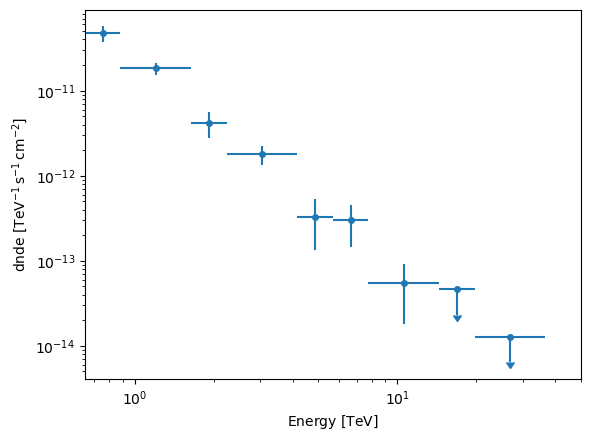

In [186]:
flux_points.plot()

#plt.savefig('Flux_dNdE.svg')

Flux points are often plotted in $E^2 \times dN/dE$:

<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='e2dnde [$\\mathrm{erg\\,s^{-1}\\,cm^{-2}}$]'>

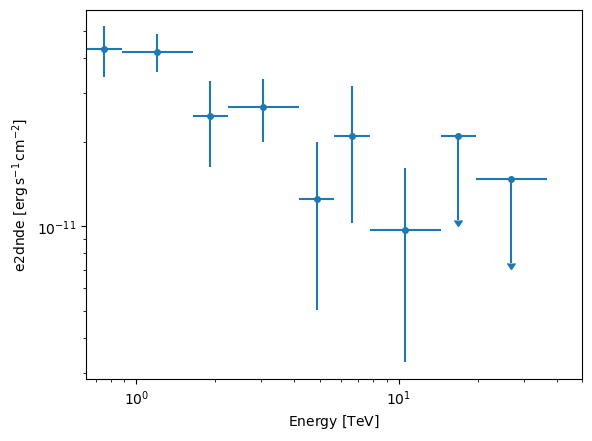

In [187]:
flux_points.plot(sed_type = 'e2dnde')

#plt.savefig('Flux_E2dNdE.svg')

We can save the points for later use.

In [188]:
flux_points.write('Crab_spectrum.ecsv',
                  overwrite = True
                 )

If we want to plot the spectral points with our best-fit model then we best use a FluxPointsDataset.

In [189]:
from gammapy.datasets import FluxPointsDataset

In [190]:
flux_points_dataset = FluxPointsDataset(data = flux_points,
                                        models = bestmodel
                                       )

(<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='e2dnde [$\\mathrm{erg\\,s^{-1}\\,cm^{-2}}$]'>,
 <Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Residuals\n (data - model) / model'>)

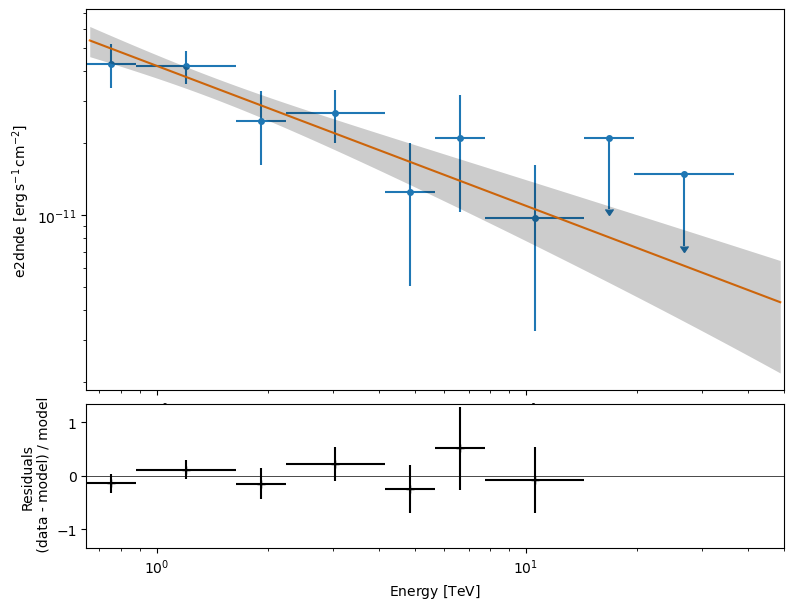

In [191]:
flux_points_dataset.plot_fit()

#plt.savefig('FluxPoints_wModel.svg')

## Your playground
You can make a spectrum with more or less data points.

In [192]:
## your code here

## Summary

That's all. Let's see what we have and summarise.

In [193]:
final_results.keys()

dict_keys(['run list', 'excess map', 'significance map', 'flux map', 'excess', 'significance', 'fit parameters', 'model type', 'flux points'])

In [194]:
print('We have found {} runs'. format(len(final_results['run list'])))

We have found 4 runs


In [195]:
print('We have detected an excess of {:4.1f} gamma rays with a statistical significance of {:3.1f} sigma.'.format(final_results['excess'], final_results['significance']))

We have detected an excess of 515.6 gamma rays with a statistical significance of 41.0 sigma.


In [196]:
print('The spectrum is best described by a {:s}.'.format(final_results['model type']))

The spectrum is best described by a PowerLawSpectralModel.


In [197]:
print('The best fit parameters are:\n', final_results['fit parameters'])

The best fit parameters are:
   type      name     value         unit      ... max frozen is_norm link
-------- --------- ---------- -------------- ... --- ------ ------- ----
spectral     index 2.5872e+00                ... nan  False   False     
spectral amplitude 2.6369e-11 TeV-1 s-1 cm-2 ... nan  False    True     
spectral reference 1.0000e+00            TeV ... nan   True   False     


In [198]:
print('The spectral data points are:\n', final_results['flux points'])

The spectral data points are:
       e_ref              e_min              e_max        ... counts success
       TeV                TeV                TeV         ...               
------------------ ------------------ ------------------ ... ------ -------
0.7536422741614978 0.6451950121482162 0.8803178367920129 ...   30.0    True
1.2011244339814315 0.8803178367920129 1.6388397980945055 ...   45.0    True
1.9143033178604023 1.6388397980945055   2.23606797749979 ...   10.0    True
3.0509388445493872   2.23606797749979 4.1627660370093675 ...   17.0    True
 4.862462362330367 4.1627660370093675  5.679766774033142 ...    3.0    True
6.6344473650486275  5.679766774033142  7.749594937741691 ...    4.0    True
10.573712634405645  7.749594937741691  14.42699905907214 ...    3.0    True
 16.85195355742642  14.42699905907214  19.68450524872506 ...    0.0    True
 26.85795883818439  19.68450524872506  36.64557192771344 ...    0.0    True
 42.80512348289246  36.64557192771344  49.99999999999999 

<WCSAxes: >

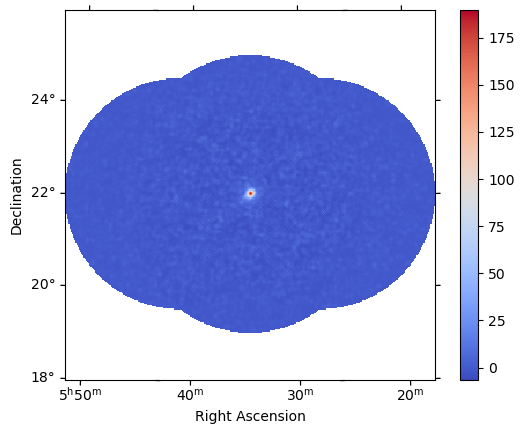

In [199]:
final_results['excess map'].plot(cmap = 'coolwarm', add_cbar = 'true')

<WCSAxes: >

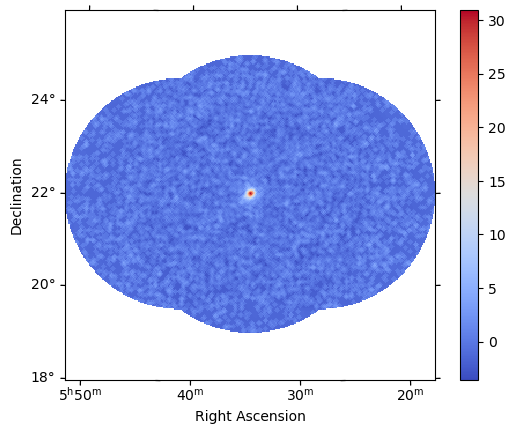

In [200]:
final_results['significance map'].plot(cmap = 'coolwarm', add_cbar = 'true')